# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
from PIL import Image
#from scipy.misc import imread, imresize
import datetime
import os
import abc
import imageio

We set the random seed so that the results don't vary drastically.

In [ ]:
# importing some other libraries which will be needed for model building.
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
#from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

**Importing and extracting dataset from zip file**

In [ ]:
!unzip -u "/content/drive/MyDrive/Colab Notebooks/GestureRecogntition/Project_data (1).zip" -d "/Project_data"

Streaming output truncated to the last 5000 lines.
 extracting: /Project_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: /Project_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: /Project_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: /Project_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: /Project_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: /Project_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: /Project_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: /Project_data/Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: /Project_data/

**Define Plotting Function**

In [ ]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
!pwd

/content


In [ ]:
project_folder = '/Project_data/Project_data'

**Various ways to read and resize image**

In [ ]:
# im = Image.open("/Project_data/Project_data/val/WIN_20180926_17_33_14_Pro_Right_Swipe_new/WIN_20180926_17_33_14_Pro_00027.png")
# im_arr = np.array(im)
# im

In [ ]:
# im_resized = im.resize((160,160))
# im_resized
# im2 = cv2.imread("/Project_data/Project_data/val/WIN_20180926_17_33_14_Pro_Right_Swipe_new/WIN_20180926_17_33_14_Pro_00027.png")
# im_resized2 = cv2.resize(im2, (160,160))
# im_resized2

# import imageio


In [ ]:
# im2 = imageio.imread("/Project_data/Project_data/val/WIN_20180926_17_33_14_Pro_Right_Swipe_new/WIN_20180926_17_33_14_Pro_00027.png").astype(float)
# print(im2.shape)
# im_resized2 = np.resize(im2, (160,160,3))
# im_resized2.shape

In [ ]:
os.listdir(project_folder)

['train', 'train.csv', 'val.csv', 'val']

In [ ]:
# train_doc = np.random.permutation(open(project_folder + '/train.csv').readlines())
# val_doc = np.random.permutation(open( project_folder + '/val.csv').readlines())
batch_size = 100 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
# var img = Image.read()

In [ ]:
class ModelInitializer(metaclass= abc.ABCMeta):
  def init_path(self,project_folder):
    self.train_doc = np.random.permutation(open(project_folder + '/train.csv').readlines())
    self.val_doc = np.random.permutation(open( project_folder + '/val.csv').readlines())
    self.train_path = project_folder + '/' + 'train'
    self.val_path =  project_folder + '/' + 'val'
    
  def init_hyper_params(self,frames_to_sample=30,batch_size=30,num_epochs=25, augment=False, ablation=None):
    self.frames_to_sample=frames_to_sample
    self.batch_size=batch_size
    self.num_epochs=num_epochs
    self.ablation = ablation
    self.augment = augment

  def populate_ablated_data(self):
    counts = np.zeros(5) # count for loading folders for 5 classes
    self.train_data = []
    self.val_data = []
    # when ablation is None pass full training and val data
    if self.ablation is not None:
        # iterating train doc
        for doc in self.train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < self.ablation:
                self.train_data.append(doc)
                counts[lable] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in self.val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < self.ablation:
                self.val_data.append(doc)
                counts[lable] += 1
    else:
        self.train_data, self.val_data = self.train_doc, self.val_doc
    
    self.num_train_sequences = len(self.train_data)
    self.num_val_sequences = len(self.val_data)

  def init_image_props(self,image_height=100,image_width=100, total_frames=30):
    self.image_height=image_height
    self.image_width=image_width
    self.channels=3 # for RGB channels
    self.num_classes=5   # As per the 5 getsures
    self.total_frames= total_frames   # As mentioned in the dataset definition, default to 30
  
  def generator(self, source_path, folder_list):
    batch_size=self.batch_size
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,self.total_frames -1, self.frames_to_sample)).astype(int)  #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)
        print("length of sequence:{}".format(len(t)))
        num_batches = len(t)//batch_size # calculate the number of batches

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx)
            yield batch_data, batch_labels
        
        remaining_seq=len(t)%batch_size

        if (remaining_seq != 0):
            batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,remaining_seq)
            yield batch_data, batch_labels

  def one_batch_data(self, source_path, t, batch, batch_size,img_idx,remaining_seq=0):
    seq_len = remaining_seq if remaining_seq else batch_size

    # print("seq_len:{}, img_idx:{},ht:{}, wt:{}".format(seq_len,len(img_idx), self.image_height,self.image_width))
    batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))   #i.e. np.zeros((batch_size,x,y,z,3)) where, x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((seq_len,self.num_classes))  # batch_labels is the one hot representation of the output
    if (self.augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

    for folder in range(seq_len):  # iterate over the batch_size/remaining seq size
      imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
      # print("folder:{} and imgs[0]{}".format(folder, imgs[0]))
      for idx,item in enumerate(img_idx):  #  Iterate over the frames/images of a folder to read them in
        # print(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
        image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
        image_resized = np.resize(image, (self.image_height,self.image_width,self.channels))
        # image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
        # image_resized = cv2.resize(image, (self.image_height,self.image_width))
        #crop the images and resize them. Note that the images are of 2 different shape 
        #and the conv3D will throw error if the inputs in a batch have different shapes

        #normalizing the images
        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

        if (self.augment):
                shifted = cv2.warpAffine(image, 
                                          np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                        (image.shape[1], image.shape[0]))
                
                gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                x0, y0 = np.argwhere(gray > 0).min(axis=0)
                x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                # cropping the images to have the targeted gestures and remove the noise from the images.
                cropped=shifted[x0:x1,y0:y1,:]
                print("type of cropped:{}".format(type(cropped)))
                # image_resized=np.array(Image.fromarray(obj=cropped,mode='F').resize(size=(self.image_height,self.image_width,self.channels)))
                image_resized = np.resize(image, (self.image_height,self.image_width,self.channels))
                #shifted = cv2.warpAffine(image_resized, 
                #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                #                        (image_resized.shape[1], image_resized.shape[0]))
        
                batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
        
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    if (self.augment):
        batch_data=np.concatenate([batch_data,batch_data_aug])
        batch_labels=np.concatenate([batch_labels,batch_labels])

    
    return(batch_data,batch_labels)


  def train_model(self, model):
        train_generator = self.generator(self.train_path, self.train_doc)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
  @abc.abstractmethod
  def define_model(self):
        pass

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
# num_train_sequences = len(train_doc)
# print('# training sequences =', num_train_sequences)
# num_val_sequences = len(val_doc)
# print('# validation sequences =', num_val_sequences)
# num_epochs = # choose the number of epochs
# print ('# epochs =', num_epochs)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
class ModelConv3D1(ModelInitializer):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv3d1 = ModelConv3D1()
conv3d1.init_path(project_folder)
conv3d1.init_image_props(image_height=160,image_width=160)
conv3d1.init_hyper_params(frames_to_sample=30,batch_size=30,num_epochs=1,augment=False)
conv3d1.populate_ablated_data()
conv3d1Model=conv3d1.define_model()
conv3d1Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

Source path =  /Project_data/Project_data/val ; batch size = 150
length of sequence:100
(100, 30, 160, 160, 3)


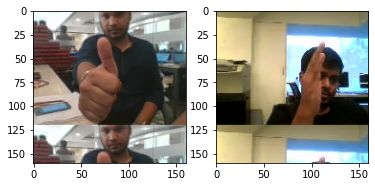

In [ ]:
test_generator=ModelConv3D1()
test_generator.init_path(project_folder)
test_generator.init_image_props(image_height=160,image_width=160)
test_generator.init_hyper_params(frames_to_sample=30,batch_size=10,num_epochs=1)
test_generator.populate_ablated_data()

g=test_generator.generator(test_generator.val_path,test_generator.val_doc)
batch_data, batch_labels=next(g)
print(batch_data.shape)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,5,:,:,:])   
axes[1].imshow(batch_data[1,18,:,:,:]) 

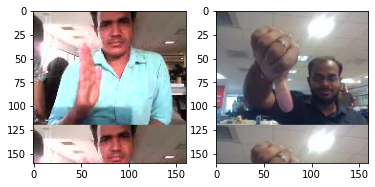

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[45,15,:,:,:])   
axes[1].imshow(batch_data[1,15,:,:,:]) 

In [ ]:
conv3d1.train_model(conv3d1Model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Source path =  /Project_data/Project_data/train ; batch size = 30
length of sequence:663
23/23 [==============================] - ETA: 0s - loss: 1.8413 - categorical_accuracy: 0.3032Source path =  /Project_data/Project_data/val ; batch size = 30
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 2.24573, saving model to model_init_2022-10-1106_20_33.697219/model-00001-1.84125-0.30317-2.24573-0.18000.h5
23/23 [==============================] - 78s 3s/step - loss: 1.8413 - categorical_accuracy: 0.3032 - val_loss: 2.2457 - val_categorical_accuracy: 0.1800 - lr: 0.0010


The model worked for batch size 30 and image=160x160 with 30 frames.

**Experimenting with the above params**

In [ ]:
conv3d2=ModelConv3D1()
conv3d2.init_path(project_folder)
conv3d2.init_image_props(image_height=100,image_width=100)
conv3d2.init_hyper_params(frames_to_sample=20,batch_size=30,num_epochs=2)
conv3d2.populate_ablated_data()
conv3d2Model=conv3d2.define_model()
print("Total Params:", conv3d2Model.count_params())
conv3d2.train_model(conv3d2Model)

Total Params: 687813
Source path =  /Project_data/Project_data/train ; batch size = 30
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 2.1963 - categorical_accuracy: 0.2775Source path =  /Project_data/Project_data/val ; batch size = 30
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.94724, saving model to model_init_2022-10-1106_38_36.518011/model-00001-2.19632-0.27753-1.94724-0.24000.h5
23/23 [==============================] - 38s 2s/step - loss: 2.1963 - categorical_accuracy: 0.2775 - val_loss: 1.9472 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/2
22/23 [===========================>..] - ETA: 1s - loss: 1.8607 - categorical_accuracy: 0.3091length of sequence:663
length of sequence:100

Epoch 2: val_loss did not improve from 1.94724
23/23 [==============================] - 36s 2s/step - loss: 1.8585 - categorical_accuracy: 0.3107 - val_loss: 3.5402 - val_categorical_accuracy: 0.2000 - lr: 0.0010


In [ ]:
conv3d2=ModelConv3D1()
conv3d2.init_path(project_folder)
conv3d2.init_image_props(image_height=100,image_width=100)
conv3d2.init_hyper_params(frames_to_sample=30,batch_size=20,num_epochs=2)
conv3d2.populate_ablated_data()
conv3d2Model=conv3d2.define_model()
print("Total Params:", conv3d2Model.count_params())
conv3d2.train_model(conv3d2Model)

Total Params: 687813
Source path =  /Project_data/Project_data/train ; batch size = 20
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
34/34 [==============================] - ETA: 0s - loss: 2.0518 - categorical_accuracy: 0.2836Source path =  /Project_data/Project_data/val ; batch size = 20
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.90731, saving model to model_init_2022-10-1106_40_03.999872/model-00001-2.05185-0.28356-1.90731-0.22000.h5
34/34 [==============================] - 55s 2s/step - loss: 2.0518 - categorical_accuracy: 0.2836 - val_loss: 1.9073 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/2
33/34 [============================>.] - ETA: 1s - loss: 1.7062 - categorical_accuracy: 0.3409length of sequence:663
length of sequence:100

Epoch 2: val_loss improved from 1.90731 to 1.88643, saving model to model_init_2022-10-1106_40_03.999872/model-00002-1.70858-0.34087-1.88643-0.18000.h5
34/34 [==============================] - 52s 2s/step - loss: 1.7086 - categorical_accuracy: 0.3409 - val_loss: 1.8864 - val_categorical_accuracy: 0.1800 - lr: 0.0010


In [ ]:
conv3d2=ModelConv3D1()
conv3d2.init_path(project_folder)
conv3d2.init_image_props(image_height=160,image_width=160)
conv3d2.init_hyper_params(frames_to_sample=30,batch_size=15,num_epochs=2)
conv3d2.populate_ablated_data()
conv3d2Model=conv3d2.define_model()
print("Total Params:", conv3d2Model.count_params())
conv3d2.train_model(conv3d2Model)

Total Params: 1736389
Source path =  /Project_data/Project_data/train ; batch size = 15
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.8190 - categorical_accuracy: 0.3243Source path =  /Project_data/Project_data/val ; batch size = 15
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.97249, saving model to model_init_2022-10-1107_56_47.605344/model-00001-1.81901-0.32428-1.97249-0.21000.h5
45/45 [==============================] - 63s 1s/step - loss: 1.8190 - categorical_accuracy: 0.3243 - val_loss: 1.9725 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.4754 - categorical_accuracy: 0.4208length of sequence:100

Epoch 2: val_loss improved from 1.97249 to 1.71402, saving model to model_init_2022-10-1107_56_47.605344/model-00002-1.47538-0.42081-1.71402-0.16000.h5
45/45 [==============================] - 61s 1s/step - loss: 1.4754 - categorical_accuracy: 0.4208 - val_loss: 1.7140 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [ ]:
conv3d2=ModelConv3D1()
conv3d2.init_path(project_folder)
conv3d2.init_image_props(image_height=120,image_width=120)
conv3d2.init_hyper_params(frames_to_sample=30,batch_size=15,num_epochs=2)
conv3d2.populate_ablated_data()
conv3d2Model=conv3d2.define_model()
print("Total Params:", conv3d2Model.count_params())
conv3d2.train_model(conv3d2Model)

Total Params: 900805
Source path =  /Project_data/Project_data/train ; batch size = 15
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.9864 - categorical_accuracy: 0.2805Source path =  /Project_data/Project_data/val ; batch size = 15
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.70622, saving model to model_init_2022-10-1106_45_53.988662/model-00001-1.98645-0.28054-1.70622-0.21000.h5
45/45 [==============================] - 57s 1s/step - loss: 1.9864 - categorical_accuracy: 0.2805 - val_loss: 1.7062 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.7137 - categorical_accuracy: 0.3620length of sequence:100

Epoch 2: val_loss did not improve from 1.70622
45/45 [==============================] - 54s 1s/step - loss: 1.7137 - categorical_accuracy: 0.3620 - val_loss: 1.8578 - val_categorical_accuracy: 0.2200 - lr: 0.0010


In [ ]:
conv3d2=ModelConv3D1()
conv3d2.init_path(project_folder)
conv3d2.init_image_props(image_height=120,image_width=120)
conv3d2.init_hyper_params(frames_to_sample=16,batch_size=15,num_epochs=2)
conv3d2.populate_ablated_data()
conv3d2Model=conv3d2.define_model()
print("Total Params:", conv3d2Model.count_params())
conv3d2.train_model(conv3d2Model)

Total Params: 900805
Source path =  /Project_data/Project_data/train ; batch size = 15
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
44/45 [============================>.] - ETA: 0s - loss: 1.9922 - categorical_accuracy: 0.2697length of sequence:663
Source path =  /Project_data/Project_data/val ; batch size = 15
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.74925, saving model to model_init_2022-10-1106_50_16.251965/model-00001-1.98873-0.26998-1.74925-0.19000.h5
45/45 [==============================] - 31s 686ms/step - loss: 1.9887 - categorical_accuracy: 0.2700 - val_loss: 1.7492 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.7554 - categorical_accuracy: 0.3620length of sequence:100

Epoch 2: val_loss improved from 1.74925 to 1.65994, saving model to model_init_2022-10-1106_50_16.251965/model-00002-1.75536-0.36199-1.65994-0.28000.h5
45/45 [==============================] - 30s 678ms/step - loss: 1.7554 - categorical_accuracy: 0.3620 - val_loss: 1.6599 - val_categorical_accuracy: 0.2800 - lr: 0.0

**From theabove we can conclude:**


*   The execution time increases with the increase in image size and frames. The batch size also plays some role
*   The batch size could be of the range 15-40
*  The image will vary between 120 and 160.

**We will decide on the above parameters as we go further in the experiment and tuning**



## Model Conv 3D

In [ ]:
class ModelConv3D1(ModelInitializer):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

#### **Batch 40, Image 160x160 and frames 20, Epcoh 15**

In [ ]:
conv3d3=ModelConv3D1()
conv3d3.init_path(project_folder)
conv3d3.init_image_props(image_height=160,image_width=160)
conv3d3.init_hyper_params(frames_to_sample=20,batch_size=40,num_epochs=15)
conv3d3.populate_ablated_data()
conv3d3Model=conv3d3.define_model()
conv3d3Model.summary()
print("Total Params:", conv3d3Model.count_params())
record_model1 = conv3d3.train_model(conv3d3Model)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_48 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_70 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_49 (Activation)  (None, 10, 80, 80, 32)  

Total Params: 1117061
Source path =  /Project_data/Project_data/train ; batch size = 40
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.8441 - categorical_accuracy: 0.3167Source path =  /Project_data/Project_data/val ; batch size = 40
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.78188, saving model to model_init_2022-10-1108_26_13.049500/model-00001-1.84407-0.31674-1.78188-0.14000.h5
17/17 [==============================] - 44s 3s/step - loss: 1.8441 - categorical_accuracy: 0.3167 - val_loss: 1.7819 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.4469 - categorical_accuracy: 0.4223length of sequence:100

Epoch 2: val_loss improved from 1.78188 to 1.54222, saving model to model_init_2022-10-1108_26_13.049500/model-00002-1.44694-0.42232-1.54222-0.28000.h5
17/17 [==============================] - 41s 3s/step - loss: 1.4469 - categorical_accuracy: 0.4223 - val_loss: 1.5422 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/15
17/17 [=====

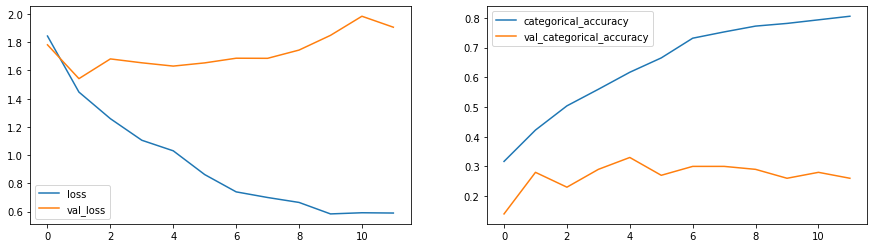

In [ ]:
plot(record_model1)

Clearly model needs more refining. Training accuracy: 80% while that of validation is only 26%

#### **Batch 40, Image 160x160 and frames 20, Epcoh 25** 
Increase the neuron density and modify the structure

In [ ]:
conv3d3=ModelConv3D1()
conv3d3.init_path(project_folder)
conv3d3.init_image_props(image_height=160,image_width=160)
conv3d3.init_hyper_params(frames_to_sample=20,batch_size=40,num_epochs=25)
conv3d3.populate_ablated_data()
conv3d3Model=conv3d3.define_model(dense_neurons=256,dropout=0.3)
conv3d3Model.summary()
print("Total Params:", conv3d3Model.count_params())
record_model1 = conv3d3.train_model(conv3d3Model)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_76 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_52 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_53 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_53 (Activation)  (None, 10, 80, 80, 32)  

Total Params: 3638981
Source path =  /Project_data/Project_data/train ; batch size = 40
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 1.9699 - categorical_accuracy: 0.3092Source path =  /Project_data/Project_data/val ; batch size = 40
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.52708, saving model to model_init_2022-10-1108_40_11.240426/model-00001-1.96993-0.30920-1.52708-0.25000.h5
17/17 [==============================] - 43s 3s/step - loss: 1.9699 - categorical_accuracy: 0.3092 - val_loss: 1.5271 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 1.4407 - categorical_accuracy: 0.4600length of sequence:100

Epoch 2: val_loss did not improve from 1.52708
17/17 [==============================] - 42s 3s/step - loss: 1.4407 - categorical_accuracy: 0.4600 - val_loss: 1.7650 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.2884 - categorical_accuracy: 0.5445length of sequence:100


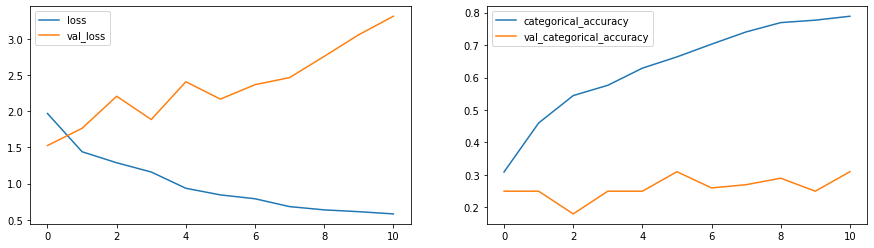

In [ ]:
plot(record_model1)

The model did not improve much. Training accuracy: 78% while that of validation is only 31%

### **Batch 40, Image 160x160 and frames 20, Epcoh 25, Filter Size (2,2,2)**

In [ ]:
conv3d3=ModelConv3D1()
conv3d3.init_path(project_folder)
conv3d3.init_image_props(image_height=160,image_width=160)
conv3d3.init_hyper_params(frames_to_sample=20,batch_size=40,num_epochs=25)
conv3d3.populate_ablated_data()
conv3d3Model=conv3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.3)
conv3d3Model.summary()
print("Total Params:", conv3d3Model.count_params())
record_model1 = conv3d3.train_model(conv3d3Model)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 20, 160, 160, 16)  400       
                                                                 
 activation_56 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_82 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_57 (Conv3D)          (None, 10, 80, 80, 32)    4128      
                                                                 
 activation_57 (Activation)  (None, 10, 80, 80, 32)  

Total Params: 3433781
Source path =  /Project_data/Project_data/train ; batch size = 40
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 1.7911 - categorical_accuracy: 0.3831Source path =  /Project_data/Project_data/val ; batch size = 40
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 2.18276, saving model to model_init_2022-10-1108_57_13.665636/model-00001-1.79107-0.38311-2.18276-0.21000.h5
17/17 [==============================] - 44s 3s/step - loss: 1.7911 - categorical_accuracy: 0.3831 - val_loss: 2.1828 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 1.4506 - categorical_accuracy: 0.4796length of sequence:100

Epoch 2: val_loss did not improve from 2.18276
17/17 [==============================] - 41s 3s/step - loss: 1.4506 - categorical_accuracy: 0.4796 - val_loss: 3.4062 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.0892 - categorical_accuracy: 0.6259length of sequence:100


### **Batch 30, Image 120x120 and frames 16, Epcoh 25, Filter Size (2,2,2), Dropout 0.5**

In [ ]:
conv3d3=ModelConv3D1()
conv3d3.init_path(project_folder)
conv3d3.init_image_props(image_height=120,image_width=120)
conv3d3.init_hyper_params(frames_to_sample=16,batch_size=30,num_epochs=25)
conv3d3.populate_ablated_data()
conv3d3Model=conv3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv3d3Model.summary()
print("Total Params:", conv3d3Model.count_params())
record_model1 = conv3d3.train_model(conv3d3Model)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_68 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_96 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_68 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_69 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_69 (Activation)  (None, 8, 60, 60, 32)   

Total Params: 1762613
Source path =  /Project_data/Project_data/train ; batch size = 30
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.3339 - categorical_accuracy: 0.2971Source path =  /Project_data/Project_data/val ; batch size = 30
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.87602, saving model to model_init_2022-10-1109_26_03.023601/model-00001-2.33386-0.29713-1.87602-0.21000.h5
23/23 [==============================] - 30s 1s/step - loss: 2.3339 - categorical_accuracy: 0.2971 - val_loss: 1.8760 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
22/23 [===========================>..] - ETA: 1s - loss: 1.9155 - categorical_accuracy: 0.3591length of sequence:663
length of sequence:100

Epoch 2: val_loss did not improve from 1.87602
23/23 [==============================] - 30s 1s/step - loss: 1.9146 - categorical_accuracy: 0.3590 - val_loss: 2.2699 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
22/23 [===========================>..] - ETA: 1s - loss: 1.7976 - categorical_accuracy: 0.3727

### **Batch 30, Image 120x120 and frames 16, Epcoh 25, Filter Size (2,2,2), Dropout 0.5 LR 0.0002**

In [ ]:
class ModelConv3D3(ModelInitializer):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv3d4=ModelConv3D3()
conv3d4.init_path(project_folder)
conv3d4.init_image_props(image_height=120,image_width=120)
conv3d4.init_hyper_params(frames_to_sample=16,batch_size=30,num_epochs=25)
conv3d4.populate_ablated_data()
conv3d4Model=conv3d4.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv3d4Model.summary()
print("Total Params:", conv3d4Model.count_params())
record_model1 = conv3d4.train_model(conv3d4Model)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_80 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_80 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_114 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_80 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_81 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_81 (Activation)  (None, 8, 60, 60, 32)   

Total Params: 1762613
Source path =  /Project_data/Project_data/train ; batch size = 30
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
22/23 [===========================>..] - ETA: 1s - loss: 2.2837 - categorical_accuracy: 0.2864length of sequence:663
Source path =  /Project_data/Project_data/val ; batch size = 30
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.67720, saving model to model_init_2022-10-1109_56_05.419634/model-00001-2.28810-0.28507-1.67720-0.25000.h5
23/23 [==============================] - 32s 1s/step - loss: 2.2881 - categorical_accuracy: 0.2851 - val_loss: 1.6772 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 2/25
22/23 [===========================>..] - ETA: 1s - loss: 1.9305 - categorical_accuracy: 0.3606length of sequence:663
length of sequence:100

Epoch 2: val_loss did not improve from 1.67720
23/23 [==============================] - 30s 1s/step - loss: 1.9273 - categorical_accuracy: 0.3620 - val_loss: 1.8182 - val_categorical_accuracy: 0.1200 - lr: 2.0000e-04
Epoch 3/25
22/23 [===========================>..] - ETA: 1s - loss: 1.6163

In [ ]:
plot(record_model1)

## Adding more layers - Model Conv 3D

In [ ]:
class ModelConv3D4(ModelInitializer):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

### **Batch 20, Image 120x120 and frames 16, Epcoh 25, Filter Size (3,3,3), Dropout 0.5**

In [ ]:
conv3d5=ModelConv3D4()
conv3d5.init_path(project_folder)
conv3d5.init_image_props(image_height=120,image_width=120)
conv3d5.init_hyper_params(frames_to_sample=16,batch_size=20,num_epochs=25)
conv3d5.populate_ablated_data()
conv3d5Model=conv3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv3d5Model.summary()
print("Total Params:", conv3d5Model.count_params())
record_model5 = conv3d5.train_model(conv3d5Model)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_100 (Conv3D)         (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_100 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_140 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_101 (Conv3D)         (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_101 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_141 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

Total Params: 2556533
Source path =  /Project_data/Project_data/train ; batch size = 20
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.5065 - categorical_accuracy: 0.2383Source path =  /Project_data/Project_data/val ; batch size = 20
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 2.37198, saving model to model_init_2022-10-1110_10_52.636083/model-00001-2.50645-0.23831-2.37198-0.19000.h5
34/34 [==============================] - 34s 911ms/step - loss: 2.5065 - categorical_accuracy: 0.2383 - val_loss: 2.3720 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 2.2274 - categorical_accuracy: 0.2851length of sequence:100

Epoch 2: val_loss did not improve from 2.37198
34/34 [==============================] - 30s 896ms/step - loss: 2.2274 - categorical_accuracy: 0.2851 - val_loss: 2.6787 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 2.1059 - categorical_accuracy: 0.2926length of sequenc

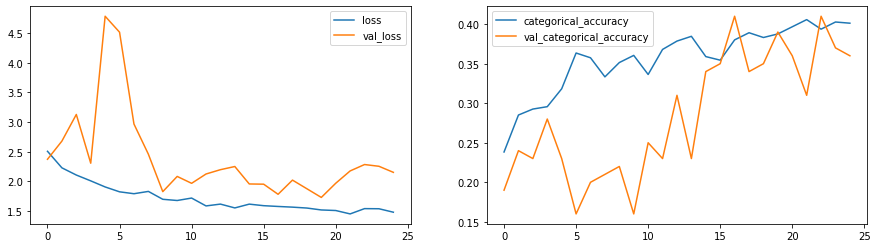

In [ ]:
plot(record_model5)

### **Batch 30, Image 120x120 and frames 16, Epcoh 25, Filter Size (2,2,2), Dropout 0.5**

In [ ]:
conv3d5=ModelConv3D4()
conv3d5.init_path(project_folder)
conv3d5.init_image_props(image_height=120,image_width=120)
conv3d5.init_hyper_params(frames_to_sample=16,batch_size=30,num_epochs=25)
conv3d5.populate_ablated_data()
conv3d5Model=conv3d5.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv3d5Model.summary()
print("Total Params:", conv3d5Model.count_params())
record_model5 = conv3d5.train_model(conv3d5Model)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_92 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_92 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_130 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_93 (Conv3D)          (None, 16, 120, 120, 16)  2064      
                                                                 
 activation_93 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_131 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

Total Params: 1937893
Source path =  /Project_data/Project_data/train ; batch size = 30
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.2734 - categorical_accuracy: 0.2760Source path =  /Project_data/Project_data/val ; batch size = 30
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 2.42989, saving model to model_init_2022-10-1110_02_59.250329/model-00001-2.27335-0.27602-2.42989-0.16000.h5
23/23 [==============================] - 34s 1s/step - loss: 2.2734 - categorical_accuracy: 0.2760 - val_loss: 2.4299 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.9730 - categorical_accuracy: 0.3198length of sequence:100

Epoch 2: val_loss did not improve from 2.42989
23/23 [==============================] - 29s 1s/step - loss: 1.9730 - categorical_accuracy: 0.3198 - val_loss: 3.3624 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.8680 - categorical_accuracy: 0.3439length of sequence:100


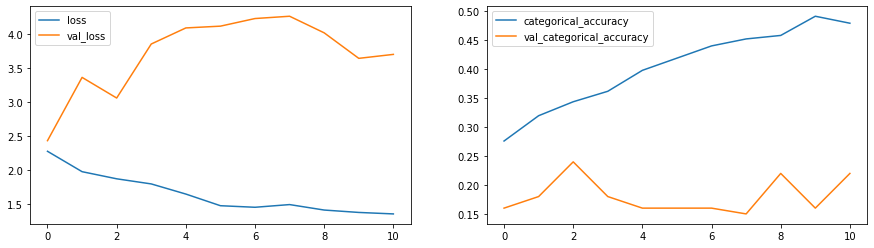

In [ ]:
plot(record_model5)

### **Reducing params by decreaseng dense network**

In [ ]:
conv3d5=ModelConv3D4()
conv3d5.init_path(project_folder)
conv3d5.init_image_props(image_height=120,image_width=120)
conv3d5.init_hyper_params(frames_to_sample=16,batch_size=20,num_epochs=25)
conv3d5.populate_ablated_data()
conv3d5Model=conv3d5.define_model(filtersize=(3,3,3),dense_neurons=128,dropout=0.5)
conv3d5Model.summary()
print("Total Params:", conv3d5Model.count_params())
record_model5 = conv3d5.train_model(conv3d5Model)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_116 (Conv3D)         (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_116 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_160 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_117 (Conv3D)         (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_117 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_161 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

Total Params: 1702645
Source path =  /Project_data/Project_data/train ; batch size = 20
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.4355 - categorical_accuracy: 0.2142Source path =  /Project_data/Project_data/val ; batch size = 20
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 3.74077, saving model to model_init_2022-10-1110_27_31.206069/model-00001-2.43549-0.21418-3.74077-0.21000.h5
34/34 [==============================] - 33s 934ms/step - loss: 2.4355 - categorical_accuracy: 0.2142 - val_loss: 3.7408 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 2.3253 - categorical_accuracy: 0.2368length of sequence:100

Epoch 2: val_loss did not improve from 3.74077
34/34 [==============================] - 30s 904ms/step - loss: 2.3253 - categorical_accuracy: 0.2368 - val_loss: 10.8845 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 2.2334 - categorical_accuracy: 0.2655length of sequen

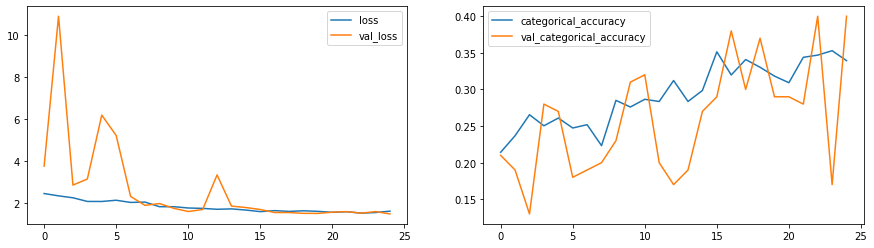

In [ ]:
plot(record_model5)

## **CNN LSTM**

In [ ]:
class RNNCNN1(ModelInitializer):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.init_path(project_folder)
rnn_cnn1.init_image_props(image_height=120,image_width=120)
rnn_cnn1.init_hyper_params(frames_to_sample=16,batch_size=20,num_epochs=25)
rnn_cnn1.populate_ablated_data()
rnn_cnn1Model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1Model.summary()
print("Total Params:", rnn_cnn1Model.count_params())
rnn_cnn1_record = rnn_cnn1.train_model(rnn_cnn1Model)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 60, 60, 32) 

Total Params: 1657445
Source path =  /Project_data/Project_data/train ; batch size = 20
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.5943 - categorical_accuracy: 0.2956Source path =  /Project_data/Project_data/val ; batch size = 20
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.72813, saving model to model_init_2022-10-1110_43_25.679961/model-00001-1.59434-0.29563-1.72813-0.18000.h5
34/34 [==============================] - 36s 937ms/step - loss: 1.5943 - categorical_accuracy: 0.2956 - val_loss: 1.7281 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5438 - categorical_accuracy: 0.3107length of sequence:100

Epoch 2: val_loss improved from 1.72813 to 1.68214, saving model to model_init_2022-10-1110_43_25.679961/model-00002-1.54378-0.31071-1.68214-0.19000.h5
34/34 [==============================] - 31s 936ms/step - loss: 1.5438 - categorical_accuracy: 0.3107 - val_loss: 1.6821 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
34/34 

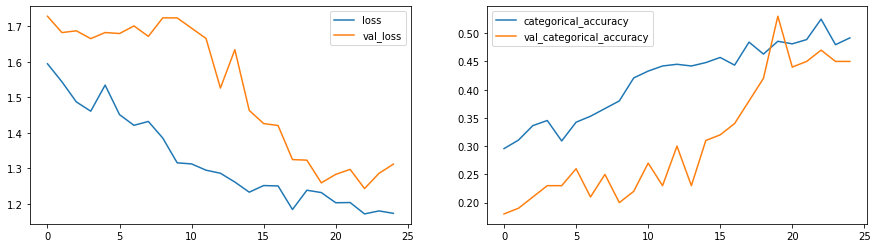

In [ ]:
plot(rnn_cnn1_record)

**We see that there is not much improvement even on adding extra layers. Changing Augmentation**

## **Augmentation Change Within the Model Initi Class**

In [ ]:
class ModelInitializerMoreAugmentation(metaclass= abc.ABCMeta):
  def init_path(self,project_folder):
    self.train_doc = np.random.permutation(open(project_folder + '/train.csv').readlines())
    self.val_doc = np.random.permutation(open( project_folder + '/val.csv').readlines())
    self.train_path = project_folder + '/' + 'train'
    self.val_path =  project_folder + '/' + 'val'
    
  def init_hyper_params(self,frames_to_sample=30,batch_size=30,num_epochs=25, augment=False, ablation=None):
    self.frames_to_sample=frames_to_sample
    self.batch_size=batch_size
    self.num_epochs=num_epochs
    self.ablation = ablation
    self.augment = augment

  def populate_ablated_data(self):
    counts = np.zeros(5) # count for loading folders for 5 classes
    self.train_data = []
    self.val_data = []
    # when ablation is None pass full training and val data
    if self.ablation is not None:
        # iterating train doc
        for doc in self.train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < self.ablation:
                self.train_data.append(doc)
                counts[lable] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in self.val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < self.ablation:
                self.val_data.append(doc)
                counts[lable] += 1
    else:
        self.train_data, self.val_data = self.train_doc, self.val_doc
    
    self.num_train_sequences = len(self.train_data)
    self.num_val_sequences = len(self.val_data)

  def init_image_props(self,image_height=100,image_width=100, total_frames=30):
    self.image_height=image_height
    self.image_width=image_width
    self.channels=3 # for RGB channels
    self.num_classes=5   # As per the 5 getsures
    self.total_frames= total_frames   # As mentioned in the dataset definition, default to 30
  
  def generator(self, source_path, folder_list):
    batch_size=self.batch_size
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,self.total_frames -1, self.frames_to_sample)).astype(int)  #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)
        print("length of sequence:{}".format(len(t)))
        num_batches = len(t)//batch_size # calculate the number of batches

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx)
            yield batch_data, batch_labels
        
        remaining_seq=len(t)%batch_size

        if (remaining_seq != 0):
            batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,remaining_seq)
            yield batch_data, batch_labels

  def one_batch_data(self, source_path, t, batch, batch_size,img_idx,remaining_seq=0):
    seq_len = remaining_seq if remaining_seq else batch_size

    # print("seq_len:{}, img_idx:{},ht:{}, wt:{}".format(seq_len,len(img_idx), self.image_height,self.image_width))
    batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))   #i.e. np.zeros((batch_size,x,y,z,3)) where, x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((seq_len,self.num_classes))  # batch_labels is the one hot representation of the output
    if (self.augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

    for folder in range(seq_len):  # iterate over the batch_size/remaining seq size
      imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
      # print("folder:{} and imgs[0]{}".format(folder, imgs[0]))
      for idx,item in enumerate(img_idx):  #  Iterate over the frames/images of a folder to read them in
        # print(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
        image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
        image_resized = np.resize(image, (self.image_height,self.image_width,self.channels))
        
        #crop the images and resize them. Note that the images are of 2 different shape 
        #and the conv3D will throw error if the inputs in a batch have different shapes

        #normalizing the images
        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

        if (self.augment):
                shifted = cv2.warpAffine(image, 
                                          np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                        (image.shape[1], image.shape[0]))
                
                gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                x0, y0 = np.argwhere(gray > 0).min(axis=0)
                x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                # cropping the images to have the targeted gestures and remove the noise from the images.
                cropped=shifted[x0:x1,y0:y1,:]

                image_resized = np.resize(image, (self.image_height,self.image_width,self.channels))

                M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                rotated_image = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))

                #shifted = cv2.warpAffine(image_resized, 
                #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                #                        (image_resized.shape[1], image_resized.shape[0]))
        
                batch_data_aug[folder,idx,:,:,0] = (rotated_image[:,:,0])/255
                batch_data_aug[folder,idx,:,:,1] = (rotated_image[:,:,1])/255
                batch_data_aug[folder,idx,:,:,2] = (rotated_image[:,:,2])/255
            
        
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    if (self.augment):
        batch_data=np.concatenate([batch_data,batch_data_aug])
        batch_labels=np.concatenate([batch_labels,batch_labels])

    
    return(batch_data,batch_labels)


  def train_model(self, model):
        train_generator = self.generator(self.train_path, self.train_doc)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
  @abc.abstractmethod
  def define_model(self):
        pass

Source path =  /Project_data/Project_data/val ; batch size = 3
length of sequence:100


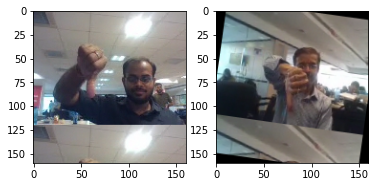

In [ ]:
class Test(ModelInitializerMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.init_path(project_folder)
test_generator.init_image_props(image_height=160,image_width=160)
test_generator.init_hyper_params(frames_to_sample=30,batch_size=3,num_epochs=1,augment=True)
test_generator.populate_ablated_data()

g=test_generator.generator(test_generator.val_path,test_generator.val_doc)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[5,29,:,:,:]) 

**Running models again with augmented configuration**

### Model Conv 3d

In [ ]:
class ModelConv3D6(ModelInitializerMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(256, filtersize, padding='same'))
        # model.add(Activation('relu'))
        # model.add(BatchNormalization())
        # model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

##### **Batch 20, Image 160x160 and frames 20, Epcoh 25**

In [ ]:
conv3d6=ModelConv3D6()
conv3d6.init_path(project_folder)
conv3d6.init_image_props(image_height=160,image_width=160)
conv3d6.init_hyper_params(frames_to_sample=20,batch_size=20,num_epochs=25,augment=True)
conv3d6.populate_ablated_data()
conv3d6Model=conv3d6.define_model(dense_neurons=256,dropout=0.5)
conv3d6Model.summary()
print("Total Params:", conv3d6Model.count_params())
conv3d_model6 = conv3d6.train_model(conv3d6Model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 32)    0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Total Params: 3638981
Source path =  /Project_data/Project_data/train ; batch size = 20
length of sequence:663
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 0.2074Source path =  /Project_data/Project_data/val ; batch size = 20
length of sequence:100
length of sequence:100

Epoch 1: val_loss did not improve from inf
34/34 [==============================] - 124s 3s/step - loss: nan - categorical_accuracy: 0.2074 - val_loss: nan - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 0.2051length of sequence:100

Epoch 2: val_loss did not improve from inf
34/34 [==============================] - 87s 3s/step - loss: nan - categorical_accuracy: 0.2051 - val_loss: nan - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 0.2051length of sequence:100

Epoch 3: 

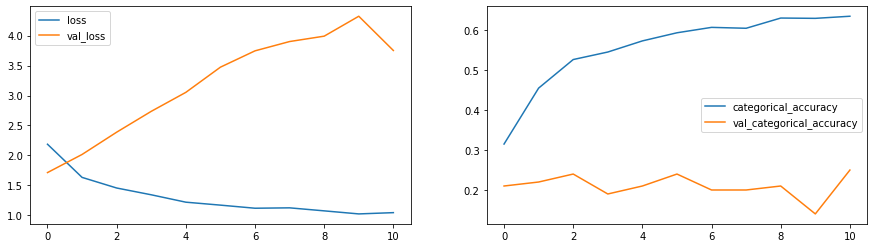

In [ ]:
plot(conv3d_model6)

#### **Batch 30, Image 160x160 and frames 16, Epcoh 25, Filter Size (2,2,2), Dropout 0.5**

In [ ]:
conv3d6=ModelConv3D6()
conv3d6.init_path(project_folder)
conv3d6.init_image_props(image_height=160,image_width=160)
conv3d6.init_hyper_params(frames_to_sample=16,batch_size=30,num_epochs=25,augment=True)
conv3d6.populate_ablated_data()
conv3d6Model=conv3d6.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv3d6Model.summary()
print("Total Params:", conv3d6Model.count_params())
conv3d_model6 = conv3d6.train_model(conv3d6Model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 160, 160, 16)  400       
                                                                 
 activation_4 (Activation)   (None, 16, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 80, 80, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 80, 80, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 8, 80, 80, 32)    

Total Params: 3433781
Source path =  /Project_data/Project_data/train ; batch size = 30
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.1863 - categorical_accuracy: 0.3152Source path =  /Project_data/Project_data/val ; batch size = 30
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.71273, saving model to model_init_2022-10-1112_27_32.922720/model-00001-2.18633-0.31523-1.71273-0.21000.h5
23/23 [==============================] - 75s 3s/step - loss: 2.1863 - categorical_accuracy: 0.3152 - val_loss: 1.7127 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.6323 - categorical_accuracy: 0.4555length of sequence:100

Epoch 2: val_loss did not improve from 1.71273
23/23 [==============================] - 69s 3s/step - loss: 1.6323 - categorical_accuracy: 0.4555 - val_loss: 2.0155 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.4551 - categorical_accuracy: 0.5271length of seque

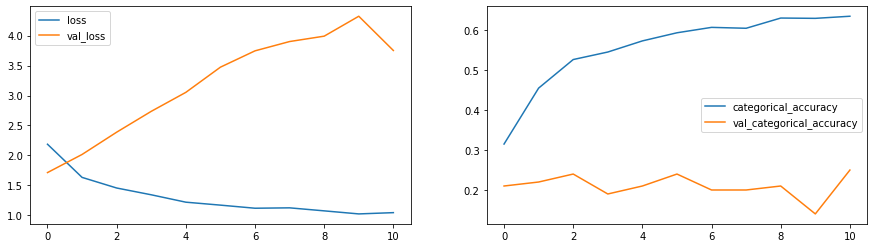

In [ ]:
plot(conv3d_model6)

#### **Batch 30, Image 120x120 and frames 16, Epcoh 25, Filter Size (2,2,2), Dropout 0.5**

In [ ]:
conv3d6=ModelConv3D6()
conv3d6.init_path(project_folder)
conv3d6.init_image_props(image_height=120,image_width=120)
conv3d6.init_hyper_params(frames_to_sample=16,batch_size=30,num_epochs=25,augment=True)
conv3d6.populate_ablated_data()
conv3d6Model=conv3d6.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv3d6Model.summary()
print("Total Params:", conv3d6Model.count_params())
conv3d_model6 = conv3d6.train_model(conv3d6Model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 16)  400       
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_9 (Activation)   (None, 8, 60, 60, 32)    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Total Params: 1762613
Source path =  /Project_data/Project_data/train ; batch size = 30
length of sequence:663
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.3038 - categorical_accuracy: 0.2941Source path =  /Project_data/Project_data/val ; batch size = 30
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.65217, saving model to model_init_2022-10-1112_43_52.730090/model-00001-2.30378-0.29412-1.65217-0.22000.h5
23/23 [==============================] - 66s 3s/step - loss: 2.3038 - categorical_accuracy: 0.2941 - val_loss: 1.6522 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/25
22/23 [===========================>..] - ETA: 2s - loss: 1.8770 - categorical_accuracy: 0.3894length of sequence:663
length of sequence:100

Epoch 2: val_loss did not improve from 1.65217
23/23 [==============================] - 59s 3s/step - loss: 1.8738 - categorical_accuracy: 0.3899 - val_loss: 1.6903 - val_categorical_accuracy: 0.2300 - l

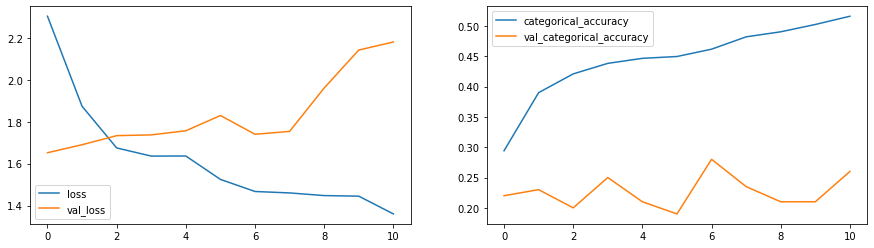

In [ ]:
plot(conv3d_model6)

### **Adding more layers - Model Conv 3d**

In [ ]:
class ModelConv3D7(ModelInitializerMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

#### **Batch 30, Image 120x120 and frames 16, Epcoh 25, Filter Size (2,2,2), Dropout 0.5**

In [ ]:
conv3d7=ModelConv3D7()
conv3d7.init_path(project_folder)
conv3d7.init_image_props(image_height=120,image_width=120)
conv3d7.init_hyper_params(frames_to_sample=16,batch_size=30,num_epochs=25,augment=True)
conv3d7.populate_ablated_data()
conv3d7Model=conv3d7.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv3d7Model.summary()
print("Total Params:", conv3d7Model.count_params())
conv3d_model7 = conv3d7.train_model(conv3d7Model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_20 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_28 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_21 (Conv3D)          (None, 16, 120, 120, 16)  2064      
                                                                 
 activation_21 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_29 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Total Params: 1937893
Source path =  /Project_data/Project_data/train ; batch size = 30
length of sequence:663
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.5559 - categorical_accuracy: 0.2451Source path =  /Project_data/Project_data/val ; batch size = 30
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.85574, saving model to model_init_2022-10-1113_03_16.499808/model-00001-2.55589-0.24510-1.85574-0.16000.h5
23/23 [==============================] - 65s 3s/step - loss: 2.5559 - categorical_accuracy: 0.2451 - val_loss: 1.8557 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 2.2977 - categorical_accuracy: 0.2790length of sequence:100

Epoch 2: val_loss did not improve from 1.85574
23/23 [==============================] - 61s 3s/step - loss: 2.2977 - categorical_accuracy: 0.2790 - val_loss: 2.0761 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/2

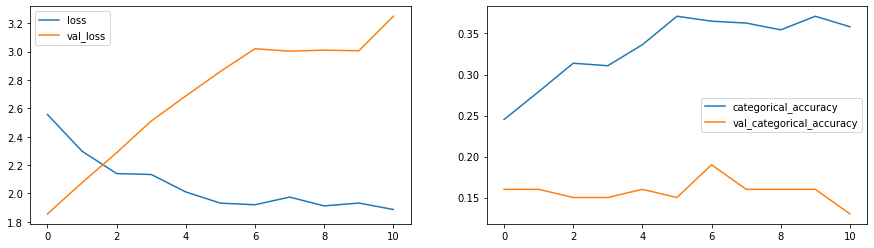

In [ ]:
plot(conv3d_model7)

#### **Batch 20, Image 120x120 and frames 16, Epcoh 25, Filter Size (3,3,3), Dropout 0.5**

In [ ]:
conv3d7=ModelConv3D7()
conv3d7.init_path(project_folder)
conv3d7.init_image_props(image_height=120,image_width=120)
conv3d7.init_hyper_params(frames_to_sample=16,batch_size=20,num_epochs=25,augment=True)
conv3d7.populate_ablated_data()
conv3d7Model=conv3d7.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv3d7Model.summary()
print("Total Params:", conv3d7Model.count_params())
conv3d_model7 = conv3d7.train_model(conv3d7Model)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_36 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_48 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_37 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_37 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_49 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

Total Params: 2556533
Source path =  /Project_data/Project_data/train ; batch size = 20
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.4884 - categorical_accuracy: 0.2662Source path =  /Project_data/Project_data/val ; batch size = 20
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.79129, saving model to model_init_2022-10-1113_19_29.387376/model-00001-2.48840-0.26621-1.79129-0.21000.h5
34/34 [==============================] - 68s 2s/step - loss: 2.4884 - categorical_accuracy: 0.2662 - val_loss: 1.7913 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 2.1565 - categorical_accuracy: 0.3069length of sequence:100

Epoch 2: val_loss did not improve from 1.79129
34/34 [==============================] - 61s 2s/step - loss: 2.1565 - categorical_accuracy: 0.3069 - val_loss: 2.1401 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 2.1003 - categorical_accuracy: 0.3137length of seque

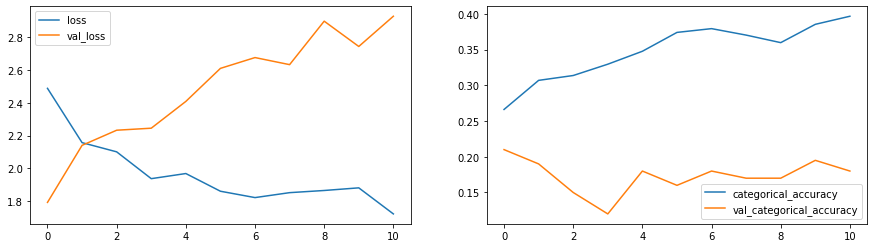

In [ ]:
plot(conv3d_model7)

### **Adding dropouts with more layers**

In [ ]:
class ModelConv3D8(ModelInitializerMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

#### **Batch 20, Image 120x120 and frames 16, Epcoh 25, Filter Size (3,3,3), Dropout 0.5**

In [ ]:
conv3d8 = ModelConv3D8()
conv3d8.init_path(project_folder)
conv3d8.init_image_props(image_height=120,image_width=120)
conv3d8.init_hyper_params(frames_to_sample=16,batch_size=20,num_epochs=25,augment=True)
conv3d8.populate_ablated_data()
conv3d8Model=conv3d8.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv3d8Model.summary()
print("Total Params:", conv3d8Model.count_params())
conv3d_hostory8 = conv3d8.train_model(conv3d8Model)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_68 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_53 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_53 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_69 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                 
 dropout_33 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 2,556,533
Trainable params: 2,554,549
Non-trainable params: 1,984
_________________________________________________________________


Total Params: 2556533
Source path =  /Project_data/Project_data/train ; batch size = 20
length of sequence:663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.6163 - categorical_accuracy: 0.2157Source path =  /Project_data/Project_data/val ; batch size = 20
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.77541, saving model to model_init_2022-10-1113_31_52.895371/model-00001-2.61634-0.21569-1.77541-0.21000.h5
34/34 [==============================] - 63s 2s/step - loss: 2.6163 - categorical_accuracy: 0.2157 - val_loss: 1.7754 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 2.5285 - categorical_accuracy: 0.2421length of sequence:100

Epoch 2: val_loss did not improve from 1.77541
34/34 [==============================] - 59s 2s/step - loss: 2.5285 - categorical_accuracy: 0.2421 - val_loss: 1.9884 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 2.3649 - categorical_accuracy: 0.2594length of seque

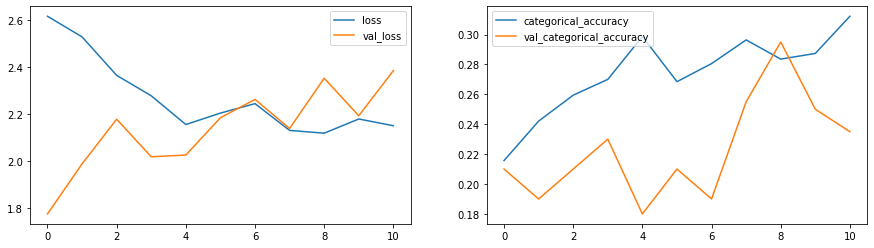

In [ ]:
plot(conv3d_hostory8)

### Model Conv 3d - Different filtersize

In [ ]:
class ModelConv3D9(ModelInitializerMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

#### **Batch 20, Image 120x120 and frames 16, Epcoh 25, dense 128,: Dropout 0.25**

In [ ]:
conv3d9 = ModelConv3D9()
conv3d9.init_path(project_folder)
conv3d9.init_image_props(image_height=120,image_width=120)
conv3d9.init_hyper_params(frames_to_sample=16,batch_size=20,num_epochs=25,augment=True)
conv3d9.populate_ablated_data()
conv3d9Model=conv3d9.define_model(dense_neurons=128,dropout=0.25)
conv3d9Model.summary()
print("Total Params:", conv3d9Model.count_params())
conv3d_hostory8 = conv3d9.train_model(conv3d9Model)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_60 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_78 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_61 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_61 (Activation)  (None, 8, 60, 60, 32)    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Total Params: 909637
Source path =  /Project_data/Project_data/train ; batch size = 20
length of sequence:663
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9824 - categorical_accuracy: 0.2934Source path =  /Project_data/Project_data/val ; batch size = 20
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.65197, saving model to model_init_2022-10-1113_49_30.674832/model-00001-1.98242-0.29336-1.65197-0.21000.h5
34/34 [==============================] - 60s 2s/step - loss: 1.9824 - categorical_accuracy: 0.2934 - val_loss: 1.6520 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5212 - categorical_accuracy: 0.4170length of sequence:100

Epoch 2: val_loss did not improve from 1.65197
34/34 [==============================] - 60s 2s/step - loss: 1.5212 - categorical_accuracy: 0.4170 - val_loss: 1.7663 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/25

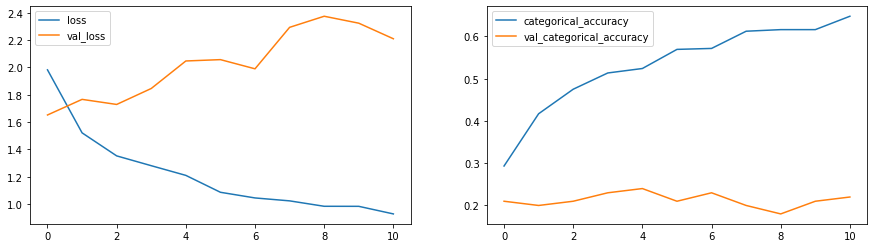

In [ ]:
plot(conv3d_hostory8)

## Augmentation Change Within the Model Initi Class - No EarlyStopping

In [ ]:
class ModelInitializerMoreAugmentationNoEarlyStopping(metaclass= abc.ABCMeta):
  def init_path(self,project_folder):
    self.train_doc = np.random.permutation(open(project_folder + '/train.csv').readlines())
    self.val_doc = np.random.permutation(open( project_folder + '/val.csv').readlines())
    self.train_path = project_folder + '/' + 'train'
    self.val_path =  project_folder + '/' + 'val'
    
  def init_hyper_params(self,frames_to_sample=30,batch_size=30,num_epochs=25, augment=False, ablation=None):
    self.frames_to_sample=frames_to_sample
    self.batch_size=batch_size
    self.num_epochs=num_epochs
    self.ablation = ablation
    self.augment = augment

  def populate_ablated_data(self):
    counts = np.zeros(5) # count for loading folders for 5 classes
    self.train_data = []
    self.val_data = []
    # when ablation is None pass full training and val data
    if self.ablation is not None:
        # iterating train doc
        for doc in self.train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < self.ablation:
                self.train_data.append(doc)
                counts[lable] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in self.val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < self.ablation:
                self.val_data.append(doc)
                counts[lable] += 1
    else:
        self.train_data, self.val_data = self.train_doc, self.val_doc
    
    self.num_train_sequences = len(self.train_data)
    self.num_val_sequences = len(self.val_data)

  def init_image_props(self,image_height=100,image_width=100, total_frames=30):
    self.image_height=image_height
    self.image_width=image_width
    self.channels=3 # for RGB channels
    self.num_classes=5   # As per the 5 getsures
    self.total_frames= total_frames   # As mentioned in the dataset definition, default to 30
  
  def generator(self, source_path, folder_list):
    batch_size=self.batch_size
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,self.total_frames -1, self.frames_to_sample)).astype(int)  #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)
        print("length of sequence:{}".format(len(t)))
        num_batches = len(t)//batch_size # calculate the number of batches

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx)
            yield batch_data, batch_labels
        
        remaining_seq=len(t)%batch_size

        if (remaining_seq != 0):
            batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,remaining_seq)
            yield batch_data, batch_labels

  def one_batch_data(self, source_path, t, batch, batch_size,img_idx,remaining_seq=0):
    seq_len = remaining_seq if remaining_seq else batch_size

    # print("seq_len:{}, img_idx:{},ht:{}, wt:{}".format(seq_len,len(img_idx), self.image_height,self.image_width))
    batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))   #i.e. np.zeros((batch_size,x,y,z,3)) where, x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((seq_len,self.num_classes))  # batch_labels is the one hot representation of the output
    if (self.augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

    for folder in range(seq_len):  # iterate over the batch_size/remaining seq size
      imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
      # print("folder:{} and imgs[0]{}".format(folder, imgs[0]))
      for idx,item in enumerate(img_idx):  #  Iterate over the frames/images of a folder to read them in
        # print(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
        image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
        image_resized = np.resize(image, (self.image_height,self.image_width,self.channels))
        
        #crop the images and resize them. Note that the images are of 2 different shape 
        #and the conv3D will throw error if the inputs in a batch have different shapes

        #normalizing the images
        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

        if (self.augment):
                shifted = cv2.warpAffine(image, 
                                          np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                        (image.shape[1], image.shape[0]))
                
                gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                x0, y0 = np.argwhere(gray > 0).min(axis=0)
                x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                # cropping the images to have the targeted gestures and remove the noise from the images.
                cropped=shifted[x0:x1,y0:y1,:]

                image_resized = np.resize(image, (self.image_height,self.image_width,self.channels))

                M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                rotated_image = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))

                #shifted = cv2.warpAffine(image_resized, 
                #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                #                        (image_resized.shape[1], image_resized.shape[0]))
        
                batch_data_aug[folder,idx,:,:,0] = (rotated_image[:,:,0])/255
                batch_data_aug[folder,idx,:,:,1] = (rotated_image[:,:,1])/255
                batch_data_aug[folder,idx,:,:,2] = (rotated_image[:,:,2])/255
            
        
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    if (self.augment):
        batch_data=np.concatenate([batch_data,batch_data_aug])
        batch_labels=np.concatenate([batch_labels,batch_labels])

    
    return(batch_data,batch_labels)


  def train_model(self, model):
        train_generator = self.generator(self.train_path, self.train_doc)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
  @abc.abstractmethod
  def define_model(self):
        pass

### Model conv 3D- Different filter Again

In [ ]:
class ModelConv3D10(ModelInitializerMoreAugmentationNoEarlyStopping):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

#### **Batch 20, Image 120x120 and frames 16, Epcoh 25, dense 64,: Dropout 0.25**

In [ ]:
conv3d10 = ModelConv3D10()
conv3d10.init_path(project_folder)
conv3d10.init_image_props(image_height=120,image_width=120)
conv3d10.init_hyper_params(frames_to_sample=16,batch_size=20,num_epochs=25,augment=True)
conv3d10.populate_ablated_data()
conv3d10Model=conv3d10.define_model(dense_neurons=64,dropout=0.25)
conv3d10Model.summary()
print("Total Params:", conv3d10Model.count_params())
conv3d_history10 = conv3d10.train_model(conv3d10Model)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_68 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_90 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_69 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_69 (Activation)  (None, 8, 60, 60, 32)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Total Params: 504709
Source path =  /Project_data/Project_data/train ; batch size = 20
length of sequence:663
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.1555 - categorical_accuracy: 0.2481Source path =  /Project_data/Project_data/val ; batch size = 20
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.79104, saving model to model_init_2022-10-1114_23_48.850609/model-00001-2.15554-0.24811-1.79104-0.16000.h5
34/34 [==============================] - 60s 2s/step - loss: 2.1555 - categorical_accuracy: 0.2481 - val_loss: 1.7910 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
33/34 [============================>.] - ETA: 1s - loss: 1.6505 - categorical_accuracy: 0.3644length of sequence:663
length of sequence:100

Epoch 2: val_loss did not improve from 1.79104
34/34 [==============================] - 59s 2s/step - loss: 1.6505 - categorical_accuracy: 0.3643 - val_loss: 1.8210 - val_categorical_accuracy: 0.2000 - lr

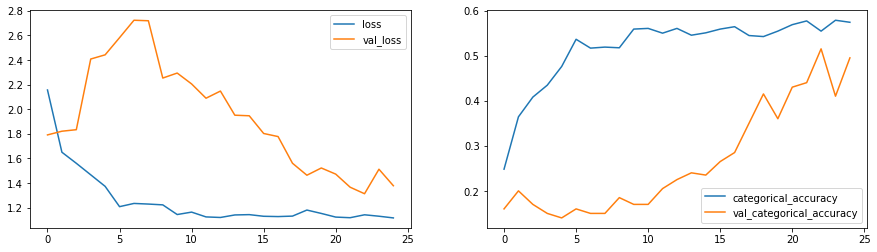

In [ ]:
plot(conv3d_history10)

### CNN LSTM GRU

In [ ]:
class RNNCNN2(ModelInitializerMoreAugmentationNoEarlyStopping):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

#### Batch 20, Image 120x120, Frames 16, Epochs 25, dense , dropout

In [ ]:
rnnCnn2=RNNCNN2()
rnnCnn2.init_path(project_folder)
rnnCnn2.init_image_props(image_height=120,image_width=120)
rnnCnn2.init_hyper_params(frames_to_sample=16,batch_size=20,num_epochs=25, augment=True)
rnnCnn2.populate_ablated_data()
rnnCnn2Model=rnnCnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.5)
rnnCnn2Model.summary()
print("Total Params:", rnnCnn2Model.count_params())
rnnCnn2_record = rnnCnn2.train_model(rnnCnn2Model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 60, 60, 32)   1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Total Params: 2573925
Source path =  /Project_data/Project_data/train ; batch size = 20
length of sequence:663
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6164 - categorical_accuracy: 0.3152Source path =  /Project_data/Project_data/val ; batch size = 20
length of sequence:100
length of sequence:100

Epoch 1: val_loss improved from inf to 1.64098, saving model to model_init_2022-10-1116_13_22.691145/model-00001-1.61640-0.31523-1.64098-0.25000.h5
34/34 [==============================] - 74s 2s/step - loss: 1.6164 - categorical_accuracy: 0.3152 - val_loss: 1.6410 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3543 - categorical_accuracy: 0.4253length of sequence:100

Epoch 2: val_loss did not improve from 1.64098
34/34 [==============================] - 59s 2s/step - loss: 1.3543 - categorical_accuracy: 0.4253 - val_loss: 1.6757 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/2

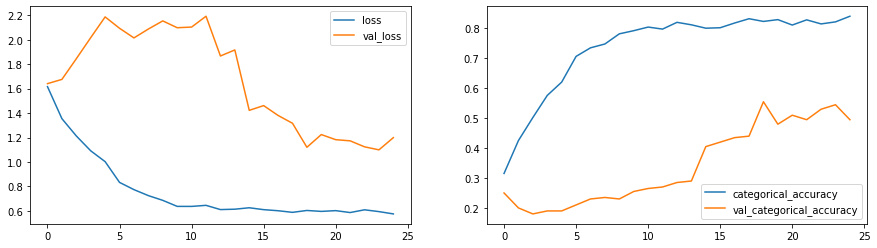

In [26]:
plot(rnnCnn2_record)

# Conclusion : Final Model


**After all the experiments, the final model is CNN LSTM model which performed relatively better than the rest of the models with accuracy and val accuracy as 51 and 53% respectively.**



*   The number of parameters is comparatively low
*   The difference in acc and val_acc is minimum
*   The validation accuracy result is still not very high and hence can wokr further to enhance the model 



